## Table of Contents

### 1. Data Loading and Preprocessing
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Image Generation using DC-GAN
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Generate random images


---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [ ]:
# # Upload data from drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# # get images
!unzip '/content/drive/MyDrive/images_dtd-200713-114828.zip'

Archive:  /content/drive/MyDrive/images_dtd-200713-114828.zip
  inflating: images_dtd/banded_0002.jpg  
  inflating: images_dtd/banded_0004.jpg  
  inflating: images_dtd/banded_0005.jpg  
  inflating: images_dtd/banded_0006.jpg  
  inflating: images_dtd/banded_0008.jpg  
  inflating: images_dtd/banded_0009.jpg  
  inflating: images_dtd/banded_0010.jpg  
  inflating: images_dtd/banded_0011.jpg  
  inflating: images_dtd/banded_0012.jpg  
  inflating: images_dtd/banded_0013.jpg  
  inflating: images_dtd/banded_0016.jpg  
  inflating: images_dtd/banded_0019.jpg  
  inflating: images_dtd/banded_0021.jpg  
  inflating: images_dtd/banded_0022.jpg  
  inflating: images_dtd/banded_0023.jpg  
  inflating: images_dtd/banded_0024.jpg  
  inflating: images_dtd/banded_0025.jpg  
  inflating: images_dtd/banded_0030.jpg  
  inflating: images_dtd/banded_0033.jpg  
  inflating: images_dtd/banded_0034.jpg  
  inflating: images_dtd/banded_0036.jpg  
  inflating: images_dtd/banded_0037.jpg  
  inflating: i

In [ ]:
!pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pytorch_model_summary import summary

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, RandomCrop, Normalize

from torch.optim import Adam

from torch.nn import Sequential
from torch.nn import Linear, LeakyReLU, BatchNorm2d, Sigmoid, Tanh, Flatten, BCELoss, Conv2d, ConvTranspose2d, ReLU

from torch.nn.init import normal_, constant_

In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [ ]:
images_dir = "/content/images_dtd"

In [ ]:
# define custom dataset class
class TextureDataset(Dataset):
    def __init__(self, images_dir):

        # get all image names
        self.image_names = os.listdir(images_dir)

        # get image paths
        self.images_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))

    def __getitem__(self, idx):

        # read data
        image = Image.open(self.images_paths[idx])

        # apply data augmentation
        transform = Compose([
                    Resize(80),
                    RandomCrop(64),
                    ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

        image = transform(image)

        return image

    def __len__(self):
        return len(self.image_names)

In [ ]:
# create instance of custom dataset
dataset = TextureDataset(images_dir)

# create dataloader
data_loader = DataLoader(
    dataset,
    batch_size=64,
    num_workers=4,
    shuffle=True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# check for one iteration of loop
for batch_x in data_loader:
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# get shapes of batches
batch_x.shape

torch.Size([64, 3, 64, 64])

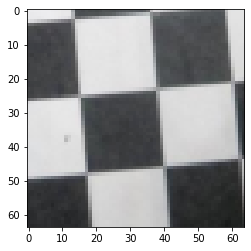

In [ ]:
# print image
image = (batch_x[0] + 1) / 2
image = np.transpose(image, (1, 2, 0))
plt.imshow(image)

In [ ]:
batch_x.min(), batch_x.max()

(tensor(-1.), tensor(1.))

### 2. Image Generation using DC-GAN

#### 2.1 Define model architecture

In [ ]:
# define discriminator model architecture

# Input
# Conv(num_filters=16, filter_size=4, stride=2, padding=1, activation='leaky_relu')
# Conv(num_filters=32, filter_size=4, stride=2, padding=1, activation='leaky_relu')
# BatchNorm()
# Conv(num_filters=64, filter_size=4, stride=2, padding=1, activation='leaky_relu')
# BatchNorm()
# Conv(num_filters=128, filter_size=4, stride=2, padding=1, activation='leaky_relu')
# BatchNorm()
# Conv(num_filters=1, filter_size=4, stride=2, padding=1, activation='sigmoid')

discriminator = Sequential(
    Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
    LeakyReLU(0.2),
    Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(128),
    LeakyReLU(0.2),
    Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    Sigmoid()
)

In [ ]:
print(summary(discriminator, batch_x[:1]))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 16, 32, 32]             768             768
       LeakyReLU-2     [1, 16, 32, 32]               0               0
          Conv2d-3     [1, 32, 16, 16]           8,192           8,192
     BatchNorm2d-4     [1, 32, 16, 16]              64              64
       LeakyReLU-5     [1, 32, 16, 16]               0               0
          Conv2d-6       [1, 64, 8, 8]          32,768          32,768
     BatchNorm2d-7       [1, 64, 8, 8]             128             128
       LeakyReLU-8       [1, 64, 8, 8]               0               0
          Conv2d-9      [1, 128, 4, 4]         131,072         131,072
    BatchNorm2d-10      [1, 128, 4, 4]             256             256
      LeakyReLU-11      [1, 128, 4, 4]               0               0
         Conv2d-12        [1, 1, 1, 1]           2,048           2,048
     

In [ ]:
# check model on one image
output = discriminator(batch_x[:1]).detach().numpy()

In [ ]:
output

array([[[[0.4228863]]]], dtype=float32)

In [ ]:
# define generator model architecture

# Input
# ConvTranspose(num_filters=128, filter_size=4, stride=1, padding=0, activation='leaky_relu')
# BatchNorm()
# ConvTranspose(num_filters=64, filter_size=4, stride=2, padding=1, activation='leaky_relu')
# BatchNorm()
# ConvTranspose(num_filters=32, filter_size=4, stride=2, padding=1, activation='leaky_relu')
# BatchNorm()
# ConvTranspose(num_filters=16, filter_size=4, stride=2, padding=1, activation='leaky_relu')
# BatchNorm()
# ConvTranspose(num_filters=3, filter_size=4, stride=2, padding=1, activation='tanh')

generator = Sequential(
    ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
    BatchNorm2d(128),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(16),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    Tanh()
)

In [ ]:
print(summary(generator, torch.randn(1, 100, 1, 1)))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
    ConvTranspose2d-1      [1, 128, 4, 4]         204,800         204,800
        BatchNorm2d-2      [1, 128, 4, 4]             256             256
          LeakyReLU-3      [1, 128, 4, 4]               0               0
    ConvTranspose2d-4       [1, 64, 8, 8]         131,072         131,072
        BatchNorm2d-5       [1, 64, 8, 8]             128             128
          LeakyReLU-6       [1, 64, 8, 8]               0               0
    ConvTranspose2d-7     [1, 32, 16, 16]          32,768          32,768
        BatchNorm2d-8     [1, 32, 16, 16]              64              64
          LeakyReLU-9     [1, 32, 16, 16]               0               0
   ConvTranspose2d-10     [1, 16, 32, 32]           8,192           8,192
       BatchNorm2d-11     [1, 16, 32, 32]              32              32
         LeakyReLU-12     [1, 16, 32,

In [ ]:
generator

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2)
  (12): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
# check model on one image
generator.eval()
output = generator(torch.randn(1, 100, 1, 1)).detach().numpy()

In [ ]:
output.shape

(1, 3, 64, 64)

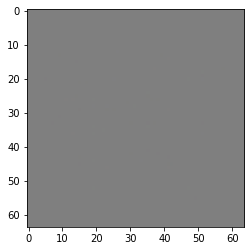

In [ ]:
# print image
image = (output + 1) / 2
image = np.transpose(image.squeeze(), (1, 2, 0))
plt.imshow(image)

In [ ]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight.data, 1.0, 0.02)
        constant_(m.bias.data, 0)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)
generator.apply(weights_init);

#### 2.2 Train the model

In [ ]:
discriminator = discriminator.to('cuda')
generator = generator.to('cuda')

In [ ]:
# Initialize BCELoss function
criterion = BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# fixed noise for plotting
fixed_noise = torch.randn(1, 100, 1, 1)

# number of epochs
num_epochs = 50

# Setup Adam optimizers for both G and D
optimizerD = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training loss for epoch 1 is 1.20069 for disciminator and 1.69666 for generator
Training loss for epoch 2 is 1.11581 for disciminator and 1.49168 for generator
Training loss for epoch 3 is 0.85800 for disciminator and 1.99391 for generator
Training loss for epoch 4 is 1.06113 for disciminator and 1.53190 for generator
Training loss for epoch 5 is 1.08707 for disciminator and 1.37158 for generator

Generated Image


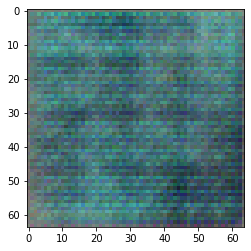

Training loss for epoch 6 is 0.88720 for disciminator and 1.81195 for generator
Training loss for epoch 7 is 0.94418 for disciminator and 1.85936 for generator
Training loss for epoch 8 is 1.10958 for disciminator and 1.60227 for generator
Training loss for epoch 9 is 0.88096 for disciminator and 1.85904 for generator
Training loss for epoch 10 is 1.04594 for disciminator and 1.69926 for generator

Generated Image


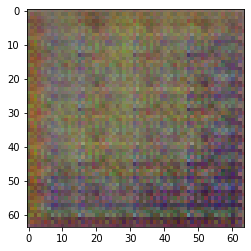

Training loss for epoch 11 is 1.10013 for disciminator and 1.68509 for generator
Training loss for epoch 12 is 1.05110 for disciminator and 1.57465 for generator
Training loss for epoch 13 is 1.13783 for disciminator and 1.35770 for generator
Training loss for epoch 14 is 0.89310 for disciminator and 1.77161 for generator
Training loss for epoch 15 is 1.06978 for disciminator and 1.50422 for generator

Generated Image


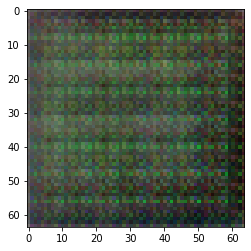

Training loss for epoch 16 is 1.11018 for disciminator and 1.43442 for generator
Training loss for epoch 17 is 0.88038 for disciminator and 1.69838 for generator
Training loss for epoch 18 is 0.87005 for disciminator and 1.78216 for generator
Training loss for epoch 19 is 1.03521 for disciminator and 1.82961 for generator
Training loss for epoch 20 is 0.79787 for disciminator and 1.91943 for generator

Generated Image


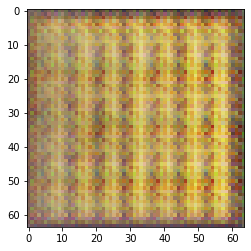

Training loss for epoch 21 is 0.96198 for disciminator and 1.84872 for generator
Training loss for epoch 22 is 0.92899 for disciminator and 1.92523 for generator
Training loss for epoch 23 is 0.92492 for disciminator and 2.07415 for generator
Training loss for epoch 24 is 1.02070 for disciminator and 1.94638 for generator
Training loss for epoch 25 is 0.88578 for disciminator and 2.04158 for generator

Generated Image


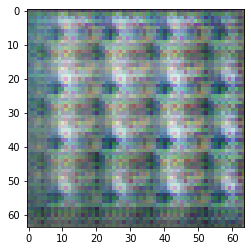

Training loss for epoch 26 is 1.03203 for disciminator and 1.94626 for generator
Training loss for epoch 27 is 1.02965 for disciminator and 1.60806 for generator
Training loss for epoch 28 is 1.15098 for disciminator and 1.46521 for generator
Training loss for epoch 29 is 1.10069 for disciminator and 1.62792 for generator
Training loss for epoch 30 is 1.03142 for disciminator and 1.80349 for generator

Generated Image


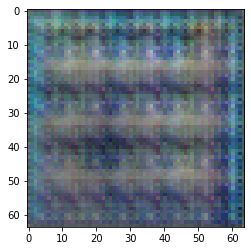

Training loss for epoch 31 is 1.09634 for disciminator and 1.78603 for generator
Training loss for epoch 32 is 1.13389 for disciminator and 1.37839 for generator
Training loss for epoch 33 is 1.03925 for disciminator and 1.55400 for generator
Training loss for epoch 34 is 1.00715 for disciminator and 1.78124 for generator
Training loss for epoch 35 is 1.08809 for disciminator and 1.80924 for generator

Generated Image


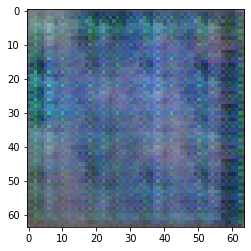

Training loss for epoch 36 is 1.02539 for disciminator and 1.75631 for generator
Training loss for epoch 37 is 0.96683 for disciminator and 2.01537 for generator
Training loss for epoch 38 is 0.89975 for disciminator and 1.87194 for generator
Training loss for epoch 39 is 0.77074 for disciminator and 2.12571 for generator
Training loss for epoch 40 is 1.01883 for disciminator and 1.87219 for generator

Generated Image


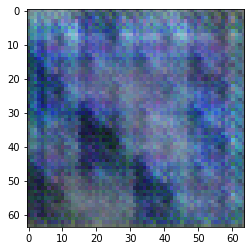

Training loss for epoch 41 is 0.84925 for disciminator and 1.89547 for generator
Training loss for epoch 42 is 0.93101 for disciminator and 1.75251 for generator
Training loss for epoch 43 is 0.98926 for disciminator and 1.78074 for generator
Training loss for epoch 44 is 0.93577 for disciminator and 1.67462 for generator
Training loss for epoch 45 is 0.93598 for disciminator and 1.87798 for generator

Generated Image


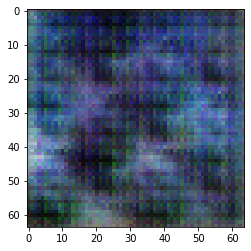

Training loss for epoch 46 is 0.83057 for disciminator and 1.84468 for generator
Training loss for epoch 47 is 0.90662 for disciminator and 1.94829 for generator
Training loss for epoch 48 is 1.00621 for disciminator and 1.77594 for generator
Training loss for epoch 49 is 0.97936 for disciminator and 1.76211 for generator
Training loss for epoch 50 is 0.96709 for disciminator and 1.78994 for generator

Generated Image


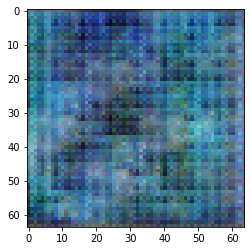

In [ ]:
# set model to train
discriminator.train()
generator.train()

# train model
for epoch in range(num_epochs):

    # initialize variables
    epochG_loss = epochD_loss = cnt = 0

    # loop through the data
    for i, batch_x in enumerate(data_loader):
        ## train discriminator

        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()

        batch_size = batch_x.shape[0]

        batch_y = torch.full((batch_size,), real_label, device="cuda")

        # clear gradients
        discriminator.zero_grad()

        # pass images to model
        outputs = discriminator(batch_x).view(-1)

        # get loss
        errD_real = criterion(outputs, batch_y.float())

        # do a backward pass
        errD_real.backward()

        generated_images = generator(torch.randn(batch_size, 100, 1, 1, device="cuda"))

        batch_y = torch.full((batch_size,), fake_label, device="cuda")

        # pass images to model
        outputs = discriminator(generated_images.detach()).view(-1)

        # get loss
        errD_fake = criterion(outputs, batch_y.float())

        # do a backward pass
        errD_fake.backward()

        # update gradients
        optimizerD.step()

        ## train generator

        # clear gradients
        generator.zero_grad()

        batch_y = torch.full((batch_size,), real_label, device="cuda")

        outputs = discriminator(generated_images).view(-1)

        # get loss
        errG = criterion(outputs, batch_y.float())

        # do a backward pass
        errG.backward()

        # add loss
        errD = errD_real + errD_fake

        # update gradients
        optimizerG.step()

        # sum loss and get count
        epochD_loss += errD.item()
        epochG_loss += errG.item()
        cnt += 1

    # take average loss for all batches
    epochD_loss /= cnt
    epochG_loss /= cnt

    # print loss
    if (epoch + 1) % 1 == 0:
        print("Training loss for epoch {} is {:.5f} for disciminator and {:.5f} for generator".format(epoch + 1, epochD_loss, epochG_loss))
    if (epoch + 1) % 5 == 0:
        print('\nGenerated Image')

        # get prediction
        generator.eval()
        with torch.no_grad():
            output = generator(fixed_noise.to('cuda')).detach().cpu().numpy()

        # plot generated image
        image = (output + 1) / 2
        image = np.transpose(image.squeeze(), (1, 2, 0))
        plt.imshow(image)
        plt.show()

        # revert back to training
        generator.train()

#### 2.3 Generate random images

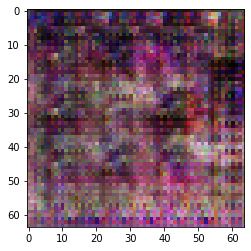

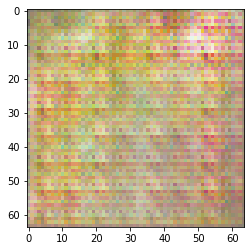

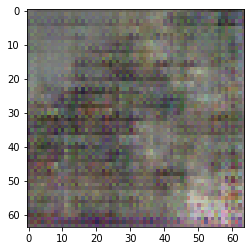

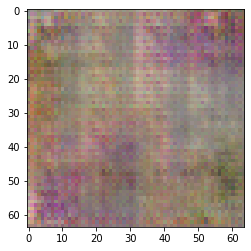

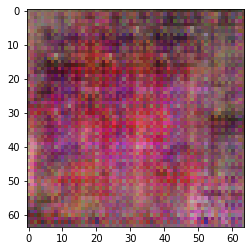

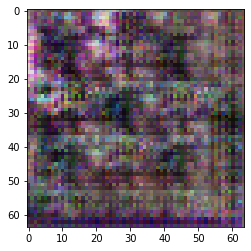

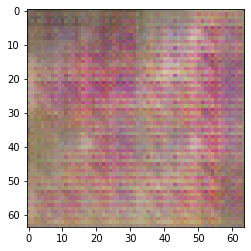

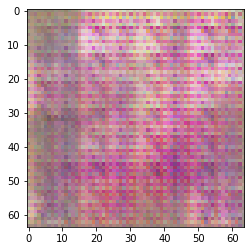

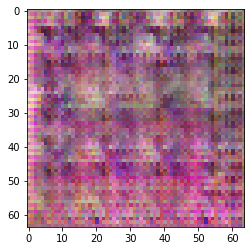

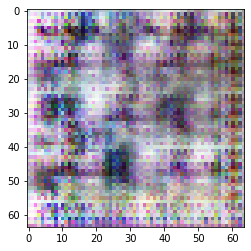

In [ ]:
# generate ten images
generator.eval()
generated_images = generator(torch.randn(10, 100, 1, 1).to('cuda')).detach().cpu().numpy()

# print image
for image in generated_images:
    image = (image + 1) / 2
    image = np.transpose(image.squeeze(), (1, 2, 0))
    plt.imshow(image)
    plt.show()

In [ ]:
generated_images.min(), generated_images.mean(), generated_images.max()

(-0.9870549, -0.019328177, 0.9947935)